In [ ]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from autograd import numpy as npa
import meep.adjoint as mpa

In [118]:
from meep.materials import Al

Air = mp.Medium(index = 1)

alq3 = mp.Medium(index = 1.68)
aNDP = mp.Medium(index = 3.6)
ITO_m = mp.Medium(index = 1.8)
SiN = mp.Medium(index = 1.9)

SiO2 = mp.Medium(index = 1.45)

wl_r = 0.65
wl_g = 0.53
wl_b = 0.45

wavelengths = np.array([wl_r, wl_g, wl_b])
frequencies = 1 / wavelengths

width = 0.2
frequencies_width = 0.1

dal = 0.3
dalq3 = 0.06
dandp = 0.06
dito = 0.16
dcoverglass = 0.08

design_region_width = 1.04
design_region_height = 2.36

dpml = 1
dair = 1

resolution = 50

full_size = dal+dalq3+dandp+dito+dcoverglass+design_region_height+dair+dpml

sx = design_region_width
sy = design_region_height
cell_size = mp.Vector3(design_region_width, full_size)

pml_layers = [mp.PML(thickness = dpml, direction=mp.Y, side = mp.High)]

# conic filter radius
eta_i=0.5
eta_e=0.55
eta_d=1-eta_e
minimum_length=0.09

filter_radius=mpa.get_conic_radius_from_eta_e(minimum_length,eta_e)

Nx=int(100)
Ny=int(1)
design_region_resolution=Nx/design_region_width

design_variables=mp.MaterialGrid(mp.Vector3(Nx,Ny),Air,SiO2,grid_type="U_MEAN")

design_region=mpa.DesignRegion(design_variables,
                               center=mp.Vector3(0,-0.5*sy+dpml+dair+0.5*design_region_height,0),
                               size=mp.Vector3(design_region_width,design_region_height))

# bloch boundary condition
k_point = mp.Vector3(0, 0, 0)  # x 방향 주기 조건 적용 (Bloch-periodic with zero phase shift)


In [119]:
# 총 셀 높이 (y 방향)
full_size = dal + dalq3 + dandp + dito + dcoverglass + design_region_height + dair + dpml  # = 5.0
cell_y_min = -full_size/2  # = -2.5

# 각 층의 중심 y 좌표를 미리 계산해 둡니다.
centers_y = []
current_bottom = cell_y_min
for thickness in [dal, dalq3, dandp, dito, dcoverglass, design_region_height, dair, dpml]:
    centers_y.append(current_bottom + thickness/2)
    current_bottom += thickness

# centers_y == [-2.35, -2.17, -2.115, -2.015, -1.905, -0.685, +1.0, +2.0]

# Meep 객체로 만들기 (예시로 Al, Alq3, AnDp, ITO, Coverglass, DesignRegion, Air, PML 순서)
geometry = [
    mp.Block(
        material=Al,
        size=mp.Vector3(mp.inf, dal, mp.inf),
        center=mp.Vector3(0, centers_y[0], 0)
    ),
    mp.Block(
        material=alq3,
        size=mp.Vector3(mp.inf, dalq3, mp.inf),
        center=mp.Vector3(0, centers_y[1], 0)
    ),
    mp.Block(
        material=aNDP,
        size=mp.Vector3(mp.inf, dandp, mp.inf),
        center=mp.Vector3(0, centers_y[2], 0)
    ),
    mp.Block(
        material=ITO_m,
        size=mp.Vector3(mp.inf, dito, mp.inf),
        center=mp.Vector3(0, centers_y[3], 0)
    ),
    mp.Block(
        material=SiN,
        size=mp.Vector3(mp.inf, dcoverglass, mp.inf),
        center=mp.Vector3(0, centers_y[4], 0)
    ),
    mp.Block(
        material=SiO2,
        size=mp.Vector3(mp.inf, design_region_height, mp.inf),
        center=mp.Vector3(0, centers_y[5], 0)
    ),
    mp.Block(
        material=Air,
        size=mp.Vector3(mp.inf, dair, mp.inf),
        center=mp.Vector3(0, centers_y[6], 0)
    ),
]

In [120]:
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    resolution=resolution,
    k_point=k_point
)

     block, center = (0,-2.36,0)
          size (1e+20,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.18,0)
          size (1e+20,0.06,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-2.12,0)
          size (1e+20,0.06,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.96,12.96,12.96)
     block, center = (0,-2.01,0)
          size (1e+20,0.16,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-1.89,0)
          size (1e+20,0.08,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (0,-0.67,0)
          size (1e+20,2.36,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric co

<Axes: xlabel='X', ylabel='Y'>

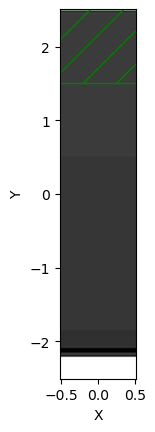

In [121]:
sim.plot2D()

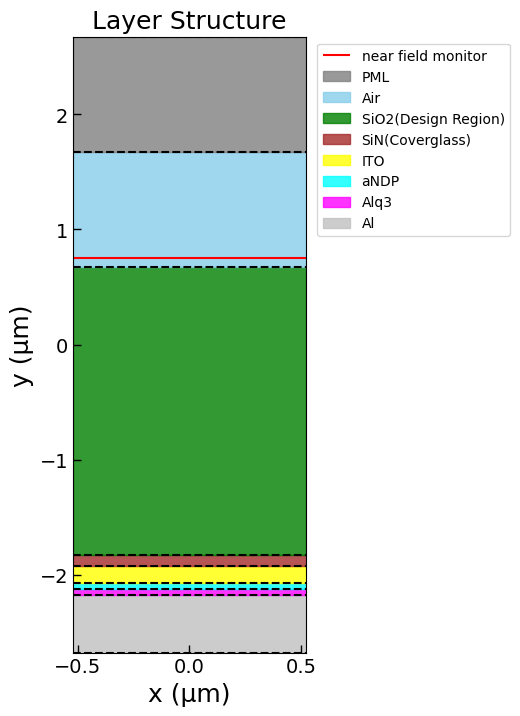

In [108]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. 기존에 정의된 두께(thickness)와 전체 높이 계산 재사용 ---
dal           = 0.5       # Al 두께
dalq3         = 0.05      # Alq3 두께
dandp         = 0.05      # aNDP 두께
dito          = 0.15      # ITO 두께
dcoverglass   = 0.1      # SiN(커버글라스) 두께
design_region_height = 2.5  # SiO2 (Design Region) 두께
dair          = 1.0       # Air 두께
dpml          = 1.0       # PML 두께

thicknesses = [dal, dalq3, dandp, dito, dcoverglass, design_region_height, dair, dpml]

full_size = sum(thicknesses)      # = 5.0 μm, 전체 높이
cell_y_min = -full_size / 2       # = -2.5 μm, y축 최소값

# 각 층의 중심 y 좌표 계산
centers_y = []
current_bottom = cell_y_min
for t in thicknesses:
    centers_y.append(current_bottom + t / 2)
    current_bottom += t

# --- 2. x 방향 범위 설정 (플롯 너비) ---
design_region_width = 1.04
x_min = -design_region_width / 2  # = -0.52 μm
x_max = +design_region_width / 2  # = +0.52 μm

# --- 3. 층별 이름과 색상 지정 ---
layer_names = ['Al', 'Alq3', 'aNDP', 'ITO', 'SiN(Coverglass)', 'SiO2(Design Region)', 'Air', 'PML']
layer_colors = ['silver', 'magenta', 'cyan', 'yellow', 'brown', 'green', 'skyblue', 'gray']

# --- 4. 플롯 생성 ---
plt.figure(figsize=(3, 8))

for i, (name, color) in enumerate(zip(layer_names, layer_colors)):
    y_bottom = centers_y[i] - thicknesses[i] / 2
    y_top    = centers_y[i] + thicknesses[i] / 2

    xs = [x_min, x_max, x_max, x_min]
    ys = [y_bottom, y_bottom, y_top, y_top]
    plt.fill(xs, ys, color=color, alpha=0.8, label=name)

# --- 5. 층 경계마다 검정색 점선(--) 그리기 ---
boundaries = [cell_y_min]
cum = cell_y_min
for t in thicknesses:
    cum += t
    boundaries.append(cum)

for y in boundaries:
    plt.hlines(y, x_min, x_max, colors='k', linestyles='--')

# --- 6. SiO2(Design Region) 상단에서 0.55 μm 지점에 'near field monitor' 빨간 선 그리기 ---
y_nf = 0.75  # near field monitor 위치 (μm)
plt.hlines(y_nf, x_min, x_max,
           colors='red',
           linestyles='-',
           linewidth=1.5,
           label='near field monitor')

# --- 7. 눈금(tick) 방향을 안쪽으로 설정 ---
plt.tick_params(axis='both',        # x축과 y축 모두
                which='major',      # 주요 눈금
                direction='in',     # 눈금을 안쪽으로
                length=6,           # 눈금 길이(픽셀 단위)
                width=1)            # 눈금 두께

fontsize_label = 18

# --- 8. 축 및 제목 설정 ---
plt.ylim(cell_y_min, cell_y_min + full_size)
plt.xlim(x_min, x_max)
plt.xlabel('x (μm)', fontsize=fontsize_label)
plt.ylabel('y (μm)', fontsize=fontsize_label)
plt.title('Layer Structure', fontsize=fontsize_label)


# 눈금(tick) 숫자(font size) 조절
plt.tick_params(axis='both',      # 'x', 'y', 또는 'both'
                which='major',    # 주요 눈금만 혹은 'both'
                labelsize=14,     # 숫자 폰트 크기
                direction='in',   # 눈금을 안쪽으로 향하게
                length=6,         # 눈금 길이
                width=1)          # 눈금 두께

# (원한다면) 숫자 포맷 변경도 함께
plt.ticklabel_format(style='plain', axis='both')  # 지수 표기가 아닌 일반 소수점 표기

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1],         # 핸들을 역순으로
           labels[::-1],          # 라벨도 역순으로
           loc='upper left',      # 범례 기준점을 "축 좌표 (bbox_to_anchor) 안에서의 상단 왼쪽" 으로 설정
           bbox_to_anchor=(1.02, 1),  # 축의 오른쪽 상단 바깥( x=1.02, y=1 )에 범례 기준점을 맞춤
           fontsize=10)
plt.ticklabel_format()
plt.show()


     block, center = (0,-2.36,0)
          size (1e+20,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.18,0)
          size (1e+20,0.06,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-2.12,0)
          size (1e+20,0.06,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.96,12.96,12.96)
     block, center = (0,-2.01,0)
          size (1e+20,0.16,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-1.89,0)
          size (1e+20,0.08,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (0,-0.67,0)
          size (1e+20,2.36,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric co

<Axes: xlabel='X', ylabel='Y'>

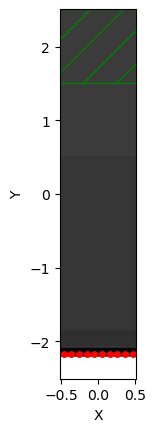

In [112]:
sim.plot2D()

     block, center = (0,-2.36,0)
          size (1e+20,0.3,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.18,0)
          size (1e+20,0.06,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-2.12,0)
          size (1e+20,0.06,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.96,12.96,12.96)
     block, center = (0,-2.01,0)
          size (1e+20,0.16,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-1.89,0)
          size (1e+20,0.08,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (0,-0.67,0)
          size (1e+20,2.36,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric co

<Axes: xlabel='X', ylabel='Y'>

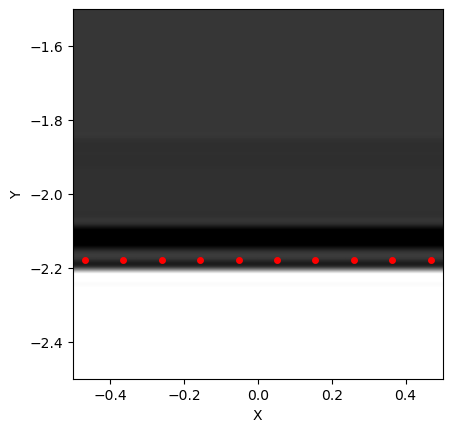

In [113]:
sim.plot2D(output_plane=mp.Volume(center=mp.Vector3(0,-2,0),size = mp.Vector3(1,1,0)))

In [91]:
from meep import Vector3
from meep import DiffractedPlanewave

monitors = []
monitor_y = y_alq3_center + 0.3

# mode 정의 (0차 회절 모드, y 방향으로 전파되는 모드)
mode = DiffractedPlanewave(
    g=[0, 0, 0],                 # 회절차수 (m_x, m_y, m_z)
    axis=mp.Vector3(0, 1, 0),    # 전파 방향
    s=1.0,                       # S-편광 성분 (Ex 방향)
    p=0.0                        # P-편광 성분 (Ey 방향)
)

for n in range(ndipole):
    x_n = -0.5 * sx + (n + 0.5) * (sx / ndipole)
    monitor_center = mp.Vector3(x_n, monitor_y)
    monitor_size = mp.Vector3(0, 0, 0)  # 포인트 모니터

    monitors.append(
        mpa.EigenmodeCoefficient(
            volume=mp.Volume(center=monitor_center, size=monitor_size),
            mode=mode,
            direction=mp.Y,
            eig_resolution=resolution
        )
    )


TypeError: __init__() missing 1 required positional argument: 'sim'

In [ ]:
# 주파수 정보
fcen = frequencies[1]  # green (중심 파장)
df = 0.1

sim.use_output_directory()  # (필요한 경우)

sim.run(
    mp.at_beginning(mp.output_epsilon),
    until_after_sources=mp.stop_when_fields_decayed(
        50, mp.Ex, mp.Vector3(), 1e-6
    )
)

# mode coefficient 계산
mode_coeffs = [monitor.get_coefficients()[0, 0] for monitor in monitors]

# 방출 모드 amplitude 확인 (복소수로 리턴됨)
for i, coeff in enumerate(mode_coeffs):
    print(f"Dipole {i} mode amplitude: {abs(coeff):.4f}, phase: {np.angle(coeff):.2f} rad")
